# Установка необходимых библиотек

In [ ]:
!pip install mtcnn

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import tensorflow as tf
from mtcnn import MTCNN
from tensorflow.keras.applications.vgg19 import preprocess_input

# Разбор как использовать веб-камеру

In [ ]:
# скачиваем изображение 
cam = cv2.VideoCapture(0)

In [ ]:
if not cam.isOpened():
    print("Не удалось открыть камеру")
else:
    print("Камера запущена")

Камера запущена


In [ ]:
# здесь мы в бесконечном цикле считываем кадр с камеры и выводим его, используя cv2.imshow()
# корректная остановка окна с камерой произойдет, когда мы нажмем q на клавиатуре 
while(True):
    ret, frame = cam.read()
    cv2.imshow("facial emotion recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

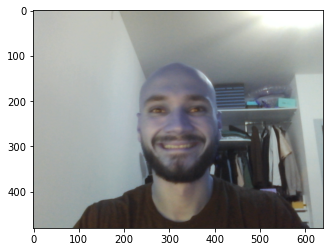

In [ ]:
ret, frame = cam.read()
if ret == True:
    plt.imshow(frame)

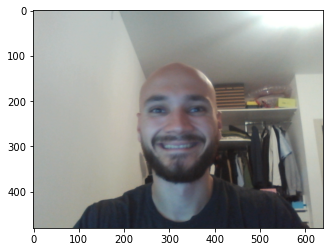

In [ ]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # переводим в формат RGB
plt.imshow(frame)

In [ ]:
detector = MTCNN()  # загружаем детектор лиц

In [ ]:
detector.detect_faces(frame)

[{'box': [224, 128, 181, 224],
  'confidence': 0.9993996620178223,
  'keypoints': {'left_eye': (277, 221),
   'right_eye': (360, 218),
   'nose': (319, 261),
   'mouth_left': (278, 292),
   'mouth_right': (366, 289)}}]

In [ ]:
y, x, h, w = detector.detect_faces(frame)[0]['box']
print(f'x={x}, y={y}, weight={w}, height={h}')

x=128, y=224, weight=224, height=181


In [ ]:
emotion_indx = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 
                5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}

In [ ]:
img = frame[x:x+w, y:y+h,:]  # обрезаем изображение по рамке

In [ ]:
model = tf.keras.models.load_model(r'vgg19_itog')  # загружаем обученную модель

In [ ]:
img_inp = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)  # размер 128*128 для входа в сеть
img_inp = preprocess_input(img_inp)  # препроцессинг для VGG19
predict_emotion = np.argmax(model.predict(img_inp[None,...]))  # получить индекс эмоции с наибольшей вероятностью
name_emotion = emotion_indx[predict_emotion]  # текстовое представление по индексу

In [ ]:
rgb_image_with_boundingbox = deepcopy(frame)  # копируем изображение, чтоб нанести на него рамку
rgb_image_with_boundingbox = cv2.rectangle(rgb_image_with_boundingbox, (y, x), (y + h, x + w), (0,255,0), 3)

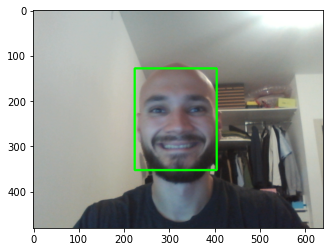

In [ ]:
plt.imshow(rgb_image_with_boundingbox)

In [ ]:
# добавляем текст эмоции
rgb_image_with_boundingbox_and_text = cv2.putText(rgb_image_with_boundingbox, 
                                                  name_emotion, 
                                                  (y, x - 10), 
                                                  cv2.FONT_HERSHEY_SIMPLEX, 
                                                  0.9, 
                                                  (0, 255, 0), 
                                                  2)

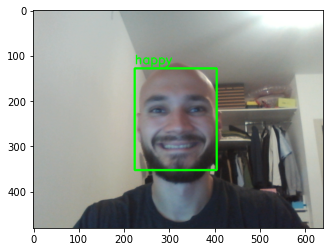

In [ ]:
plt.imshow(rgb_image_with_boundingbox_and_text)

### Распознавание эмоций в режиме реального времени

In [ ]:
def preprocess_image(img):
    img = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)  # размер 128*128 для входа в сеть
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # преобразуем в формат RGB
    img = preprocess_input(img)  # препроцессинг для VGG19
    return img
def pred_model(img, model):
    emotion_indx = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 
                    5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
    predict_emotion = np.argmax(model.predict(img[None,...]))  # получить индекс эмоции с наибольшей вероятностью
    name_emotion = emotion_indx[predict_emotion]  # текстовое представление по индексу
    return name_emotion

cap = cv2.VideoCapture(0) # запуск камеры
detector = MTCNN()  # использую детектор MTCNN
model = tf.keras.models.load_model(r'vgg19_itog')  # загружаем обученную модель
while(True):
    ret, frame = cam.read()
    if ret:
        detect_face = detector.detect_faces(frame)
        if len(detect_face) > 0:
            y, x, h, w = detect_face[0]['box']
            img_inp = frame[x:x+w, y:y+h,:]
            img_inp = preprocess_image(img_inp)
            predict_emotion = pred_model(img_inp, model)
            rgb_image_with_boundingbox = cv2.rectangle(frame, (y, x), (y + h, x + w), (0,255,0), 3)
            rgb_image_with_boundingbox_and_text = cv2.putText(rgb_image_with_boundingbox, 
                                                              predict_emotion, 
                                                              (y, x - 10), 
                                                              cv2.FONT_HERSHEY_SIMPLEX, 
                                                              0.9, 
                                                              (0, 255, 0), 
                                                              2)
        else:
            pass
        cv2.imshow("facial emotion recognition", rgb_image_with_boundingbox_and_text)
    else:
        cv2.imshow("facial emotion recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        


# Напишем класс для создания модели, которая определяет эмоции и выводит рамку

In [ ]:
class EmotionDetected():
    """Класс EmotionDetected используется для классификации эмоции
    Используется детектор MT-CNN
    
    Attributes
    ----------
    config : str
        полный путь до модели

    Methods
    -------
    emo_detect(image)
        На вход изображение.
        Возвращает изображение, на котором лица выделены в bounding box с 
        указанием эмоции 
    """
    def __init__(self, config:str):
        self.config = config  # путь к модели (формат строка)
        self.model = tf.keras.models.load_model(self.config)  # загружаем модель
        self.detector = MTCNN()  # инициализируем детектор
        
    def preprocess_image(self, img):
        img = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)  # размер 128*128 для входа в сеть
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # преобразуем в формат RGB
        img = preprocess_input(img)  # препроцессинг для VGG19
        return img
    
    def pred_model(self, img):
        emotion_indx = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 
                        5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
        predict_emotion = np.argmax(self.model.predict(img[None,...]))  # получить индекс эмоции с наибольшей вероятностью
        name_emotion = emotion_indx[predict_emotion]  # текстовое представление по индексу
        return name_emotion

    def emo_detect(self, frame):
        detect = self.detector.detect_faces(frame)
        if len(detect) > 0:
            for box in detect:
                y, x, h, w = box['box']
                img_inp = frame[x:x+w, y:y+h,:]
                img_inp = self.preprocess_image(img_inp)
                predict_emotion = self.pred_model(img_inp)
                frame = cv2.rectangle(frame, (y, x), (y + h, x + w), (0,255,0), 3)
                frame = cv2.putText(frame, 
                                    predict_emotion, 
                                    (y, x - 10), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 
                                    0.9, 
                                    (0, 255, 0), 
                                    2)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.imshow(frame)

In [ ]:
model_itog = EmotionDetected(r'vgg19_itog')

In [ ]:
img1 = cv2.imread("./1.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("./2.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

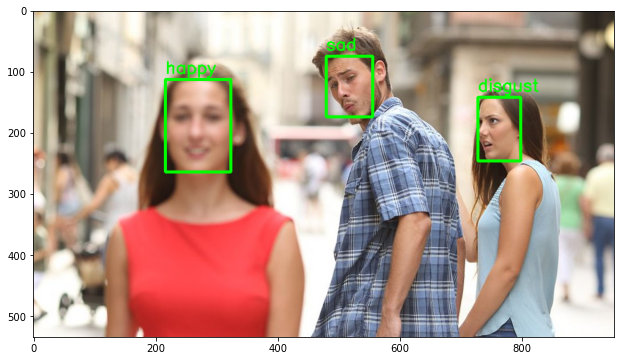

In [ ]:
model_itog.emo_detect(img1)

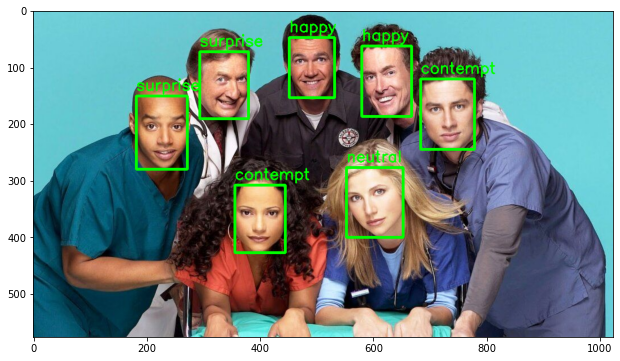

In [ ]:
model_itog.emo_detect(img2)

# Работа распознавания эмоций в режиме реального времени

## С детектором MTCNN()

In [ ]:
class EmotionVideo():
    """Класс EmotionVideo используется для классификации эмоции
    Используется детектор MT-CNN
    
    Attributes
    ----------
    config : str
        полный путь до модели

    Methods
    -------
    realtime_emotion()
        Запускает окно с камерой и отображает эмоцию в режиме реального времени
    """
    def __init__(self, config:str):
        self.config = config  # путь к модели (формат строка)
        self.model = tf.keras.models.load_model(self.config)  # загружаем модель
        self.detector = MTCNN()  # инициализируем детектор
    
    def preprocess_image(self, img):
        img = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)  # размер 128*128 для входа в сеть
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # преобразуем в формат RGB
        img = preprocess_input(img)  # препроцессинг для VGG19
        return img
    
    def pred_model(self, img):
        emotion_indx = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 
                        5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
        img = self.preprocess_image(img)
        predict_emotion = np.argmax(self.model.predict(img[None,...]))  # получить индекс эмоции с наибольшей вероятностью
        name_emotion = emotion_indx[predict_emotion]  # текстовое представление по индексу
        return name_emotion
        
    def realtime_emotion(self):
        cam = cv2.VideoCapture(0) # запуск камеры
        while(True):
            ret, frame = cam.read()
            if ret:
                detect = self.detector.detect_faces(frame)
                if len(detect) > 0:
                    y, x, h, w = detect[0]['box']
                    img_inp = frame[x:x+w, y:y+h,:]
                    predict_emotion = self.pred_model(img_inp)
                    rgb_image_with_boundingbox = cv2.rectangle(frame, (y, x), (y + h, x + w), (0,255,0), 3)
                    rgb_image_with_boundingbox_and_text = cv2.putText(rgb_image_with_boundingbox, 
                                                                      predict_emotion, 
                                                                      (y, x - 10), 
                                                                      cv2.FONT_HERSHEY_SIMPLEX, 
                                                                      0.9, 
                                                                      (0, 255, 0), 
                                                                      2)
                    frame = rgb_image_with_boundingbox_and_text
                else:
                    pass
                cv2.imshow("facial emotion recognition", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

In [ ]:
model_video = EmotionVideo(r'vgg19_itog')

In [ ]:
model_video.realtime_emotion()

## С детектором OpenCV

In [ ]:
class EmotionVideoCv():
    """Класс EmotionVideoCv используется для классификации эмоции
    Используется детектор основанный на методе Виолы-Джонсона и признаках Хаара
    
    Attributes
    ----------
    config : str
        полный путь до модели

    Methods
    -------
    realtime_emotion()
        Запускает окно с камерой и отображает эмоцию в режиме реального времени
    """
    def __init__(self, config:str):
        self.config = config  # путь к модели (формат строка)
        self.model = tf.keras.models.load_model(self.config)  # загружаем модель
        self.detector = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')  # инициализируем детектор
    
    def preprocess_image(self, img):
        img = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)  # размер 128*128 для входа в сеть
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # преобразуем в формат RGB
        img = preprocess_input(img)  # препроцессинг для VGG19
        return img
    
    def pred_model(self, img):
        emotion_indx = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 
                        5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
        img = self.preprocess_image(img)
        predict_emotion = np.argmax(self.model.predict(img[None,...]))  # получить индекс эмоции с наибольшей вероятностью
        name_emotion = emotion_indx[predict_emotion]  # текстовое представление по индексу
        return name_emotion
        
    def realtime_emotion(self):
        cam = cv2.VideoCapture(0) # запуск камеры
        cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640) # ширина кадра -- 640 пикселей
        cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # высота кадра -- 480 пикселей
        while(True):
            ret, frame = cam.read()
            if ret:
                detect = self.detector.detectMultiScale(frame)
                if len(detect) > 0:
                    x, y, w, h = detect[0]
                    img_inp = frame[y:y+h, x:x+w]
                    predict_emotion = self.pred_model(img_inp)
                    rgb_image_with_boundingbox = cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,0), 3)
                    rgb_image_with_boundingbox_and_text = cv2.putText(rgb_image_with_boundingbox, 
                                                                      predict_emotion, 
                                                                      (x, y - 10), 
                                                                      cv2.FONT_HERSHEY_SIMPLEX, 
                                                                      0.9, 
                                                                      (0, 255, 0), 
                                                                      2)
                    frame = rgb_image_with_boundingbox_and_text
                else:
                    pass
                cv2.imshow("facial emotion recognition", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

In [ ]:
model_video_itog = EmotionVideoCv(r'vgg19_itog')

In [ ]:
model_video_itog.realtime_emotion()

# Вывод: Наглядно быстрее работает модель распознавания эмоций с детектором OpenCV.

# Скрины работы веб-камеры

In [ ]:
import os

In [ ]:
count_file = os.listdir('./out_cam')

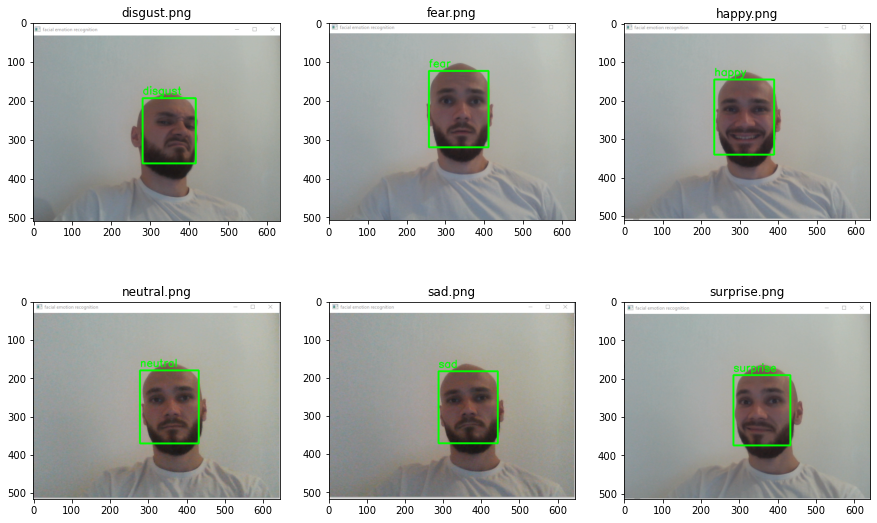

In [ ]:
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=3)
i=0
for img_file in count_file:
    img_out = cv2.cvtColor(cv2.imread(f'./out_cam/{img_file}'), cv2.COLOR_BGR2RGB)
    ax = axs[i//3, i%3]
    ax.imshow(img_out)
    ax.set_title(img_file)
    i +=1
plt.subplots_adjust(hspace=0.05, wspace=0.2)
plt.show()